In [1]:
from matplotlib import patches
from matplotlib import rcParams
from scipy import stats
import pandas as pd
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.stats import sigma_clipped_stats
from astropy.table import Table, Column, setdiff, join, unique
from photutils import detect_sources, deblend_sources
from photutils import CircularAperture, CircularAnnulus

from astroquery.vizier import Vizier
from astropy import units as u
from astropy.coordinates import SkyCoord
import re

from utils import *

rcParams.update({'xtick.major.pad': '5.0'})
rcParams.update({'xtick.major.size': '4'})
rcParams.update({'xtick.major.width': '1.'})
rcParams.update({'xtick.minor.pad': '5.0'})
rcParams.update({'xtick.minor.size': '4'})
rcParams.update({'xtick.minor.width': '0.8'})
rcParams.update({'ytick.major.pad': '5.0'})
rcParams.update({'ytick.major.size': '4'})
rcParams.update({'ytick.major.width': '1.'})
rcParams.update({'ytick.minor.pad': '5.0'})
rcParams.update({'ytick.minor.size': '4'})
rcParams.update({'ytick.minor.width': '0.8'})
rcParams.update({'font.size': 15})
rcParams.update({'font.serif': 'Times New Roman'})


save = False
draw = True

mu: 884.42 , std: 4.96 , ZP: 27.10 , pix_scale: 2.50


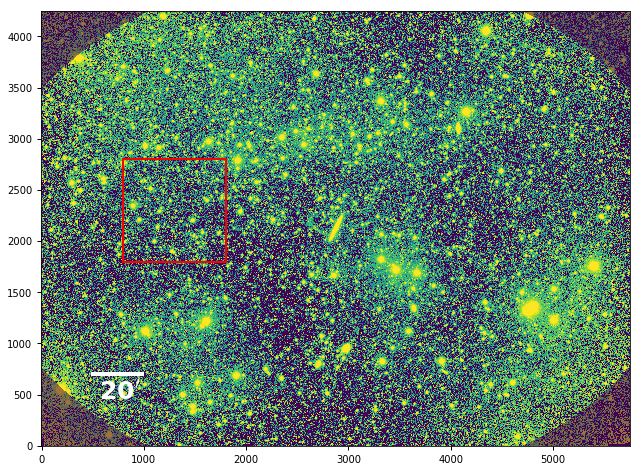

In [11]:
############################################
# Read 
############################################

hdu = fits.open("./coadd_SloanR_NGC_5907.fits")[0]
data = hdu.data
header = hdu.header
wcs_data = wcs.WCS(header)

seeing = 2.5
# Runned from create_photometric_light_APASS 
seg_map = fits.open("./SE_APASS/coadd_SloanR_NGC_5907_seg.fits")[0].data
weight_edge_map = fits.open("./weight_NGC5907.fits")[0].data
SE_cat_full = Table.read("./SE_APASS/coadd_SloanR_NGC_5907.cat", format="ascii.sextractor")

mu, std = np.float(hdu.header["BACKVAL"]), mad_std(hdu.data[seg_map==0&(weight_edge_map>0.5)]) 
ZP, pix_scale = np.float(hdu.header["REFZP"]), np.float(hdu.header["PIXSCALE"])
print("mu: %.2f , std: %.2f , ZP: %.2f , pix_scale: %.2f" %(mu, std, ZP, pix_scale))

SE_cat_full["RMAG_AUTO"] = -2.5*np.log10(SE_cat_full["FLUX_AUTO"]) + ZP

############################################
# Crop
############################################

patch_Xmin, patch_Ymin, patch_Xmax, patch_Ymax = 800, 1800, 1800, 2800  # image coords
image_bounds = (patch_Xmin, patch_Ymin, patch_Xmax, patch_Ymax)

def crop_image(data, seg_map, bounds, draw=False):
    patch_Xmin, patch_Ymin, patch_Xmax, patch_Ymax = bounds
    patch_xmin, patch_ymin = coord_Im2Array(patch_Xmin, patch_Ymin)
    patch_xmax, patch_ymax = coord_Im2Array(patch_Xmax, patch_Ymax)

    patch = np.copy(data[patch_xmin:patch_xmax, patch_ymin:patch_ymax])
    seg_patch = np.copy(seg_map[patch_xmin:patch_xmax, patch_ymin:patch_ymax])
    
    if draw:
        fig, ax = plt.subplots(figsize=(12,8))
        plt.imshow(data*weight_edge_map, vmin=mu, vmax=mu+10*std, norm=norm1, origin="lower", cmap="viridis")
        plt.imshow(data, vmin=mu, vmax=mu+10*std, norm=norm1, origin="lower", cmap="viridis",alpha=0.5)
        plt.plot([500,980],[700,700],"w",lw=4)
        plt.text(560,450, r"$\bf 20'$",color='w', fontsize=25)
        rect = patches.Rectangle((patch_ymin,patch_xmin),1000,1000,linewidth=2,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        plt.show()
        
    return patch, seg_patch

patch, seg_patch = crop_image(data, seg_map, image_bounds, draw=True)

In [12]:
############################################
# Crossmatch
############################################

def query_vizier(catalog_name, radius, columns, column_filters, header=header):
    # Prepare for quearyinig Vizier with filters up to infinitely many rows. By default, this is 50.
    viz_filt = Vizier(columns=columns, column_filters=column_filters)
    viz_filt.ROW_LIMIT = -1

    RA, DEC = re.split(",", header['RADEC'])
    coords = SkyCoord(RA+" "+DEC , unit=(u.hourangle, u.deg))

    # Query!
    result = viz_filt.query_region(coords, 
                                   radius=radius, 
                                   catalog=[catalog_name])
    return result

def transform_coords2pixel(tab, cat_name, w=wcs_data, RA_key="RAJ2000", DE_key="DEJ2000"):
    coords = np.vstack([np.array(tab[RA_key]), 
                        np.array(tab[DE_key])]).T
    pos = w.wcs_world2pix(coords, 1)
    tab.add_column(Column(np.around(pos[:,0], 4)*u.pix), name='X_IMAGE'+'_'+cat_name)
    tab.add_column(Column(np.around(pos[:,1], 4)*u.pix), name='Y_IMAGE'+'_'+cat_name)
    tab.add_column(Column(np.arange(len(tab))+1), index=0, name="ID"+'_'+cat_name)
    return tab

result = query_vizier(catalog_name="URAT", radius=2*u.deg,
                      columns=['RAJ2000', 'DEJ2000', 'mfa', 'gmag', 'e_gmag', 'rmag', 'e_rmag'],
                      column_filters={'mfa':'=1', 'rmag':'{0} .. {1}'.format(8, 18)})

Cat_URAT = result['I/329/urat1']
Cat_URAT = transform_coords2pixel(Cat_URAT, cat_name="URAT")     
print("URAT Brightest Star: %.3f"%Cat_URAT["rmag"].min())
    
result = query_vizier(catalog_name="USNO", radius=2*u.deg,
                      columns=['RAJ2000', 'DEJ2000', "Bmag","Rmag"],
                      column_filters={"Rmag":'{0} .. {1}'.format(5, 15)})

Cat_USNO = result['I/252/out']
Cat_USNO = transform_coords2pixel(Cat_USNO, cat_name="USNO")
print("USNO Brightest Star: %.3f"%Cat_USNO["Rmag"].min())

############################################
# Merge Catalog
############################################

def merge_catalog(SE_catalog, table_merge, sep=2.5 * u.arcsec,
                  RA_key="RAJ2000", DE_key="DEJ2000", keep_columns=None):
    
    c_SE = SkyCoord(ra=SE_catalog["X_WORLD"], dec=SE_catalog["Y_WORLD"])

    c_tab = SkyCoord(ra=table_merge[RA_key], dec=table_merge[DE_key])
    idx, d2d, d3d = c_SE.match_to_catalog_sky(c_tab)
    match = d2d < sep
    cat_SE_match = SE_catalog[match]
    cat_tab_match = table_merge[idx[match]]
    
    cat_tab_match.add_column(cat_SE_match["NUMBER"], index=0, name="NUMBER")
    cat_match = join(cat_SE_match, cat_tab_match, keys='NUMBER')
    
    if keep_columns is not None:
        cat_match.keep_columns(keep_columns)
    
    df_match = cat_match.to_pandas()
    return df_match

df_match_URAT = merge_catalog(SE_cat_full, Cat_URAT, sep=2.5*u.arcsec, 
                               keep_columns=["NUMBER","X_IMAGE","Y_IMAGE","ELLIPTICITY","RMAG_AUTO",
                                             "ID_URAT","X_IMAGE_URAT","Y_IMAGE_URAT","rmag","gmag","FLAGS"])
df_match_USNO = merge_catalog(SE_cat_full, Cat_USNO, sep=5*u.arcsec,
                               keep_columns=["NUMBER","X_IMAGE","Y_IMAGE","ELLIPTICITY","RMAG_AUTO",
                                             "ID_USNO","X_IMAGE_USNO","Y_IMAGE_USNO","Rmag","FLAGS"])

df_SE_match_all = pd.merge(df_match_URAT, df_match_USNO, how='outer')

bounds = (patch_Xmin-200, patch_Ymin-200, patch_Xmax+200, patch_Ymax+200)
df_SE_match = crop_catalog(df_SE_match_all, bounds, keys=("X_IMAGE", "Y_IMAGE"))
df_SE_match = df_SE_match.reset_index(drop=True)

target = df_SE_match["RMAG_AUTO"] < 15
df_SE_target = df_SE_match[target]
df_SE_target

URAT Brightest Star: 10.021
USNO Brightest Star: 7.000


,NUMBER,X_IMAGE,Y_IMAGE,ELLIPTICITY,FLAGS,RMAG_AUTO,ID_URAT,gmag,rmag,X_IMAGE_URAT,Y_IMAGE_URAT,ID_USNO,Rmag,X_IMAGE_USNO,Y_IMAGE_USNO
0,10981,1318.3895,2985.3862,0.055,2,14.760577,3216.0,15.121000,14.633,1318.2525,2985.3486,2905.0,14.6,1318.0346,2985.2190
1,10985,609.3795,2999.0608,0.094,3,13.899152,3344.0,14.227000,13.741,609.2384,2999.0667,3352.0,13.5,609.0335,2999.4069
5,11154,1078.7504,2988.9346,0.069,0,14.168863,3223.0,14.832000,13.990,1078.6116,2989.0149,3070.0,13.8,1078.5596,2990.0340
7,11228,924.9524,2979.1204,0.132,0,13.406135,3081.0,14.530000,13.228,924.6094,2979.0256,NaN,NaN,NaN,NaN
9,11293,1734.4144,2961.5969,0.046,6,11.809956,3185.0,11.856000,11.100,1734.1376,2961.5843,2581.0,11.6,1733.7508,2961.6677
10,11360,1105.9899,2966.5188,0.142,4,12.764730,3220.0,13.348000,12.561,1105.7555,2966.5095,3049.0,12.5,1105.7255,2966.5771
11,11383,1008.5241,2901.5034,0.305,3,14.678931,3079.0,15.081000,14.571,1008.4698,2901.4529,3123.0,14.6,1008.5057,2901.6069
13,11411,1819.5680,2965.5864,0.104,0,14.547001,3552.0,14.791000,14.418,1819.5034,2965.6093,2518.0,14.3,1819.4052,2965.8912
16,11471,1348.5474,2949.1829,0.077,2,13.679416,3208.0,13.773000,13.526,1348.4527,2949.1879,2879.0,13.6,1348.5022,2949.4691
17,11478,1939.9355,2943.9451,0.097,6,11.281835,3532.0,10.529000,10.036,1939.6365,2943.8519,2427.0,10.9,1939.1548,2943.3189


In [15]:
############################################
# Measure
############################################

def get_star_pos(id, star_cat, ref_pos=(0,0)):
    X_c, Y_c = star_cat[id]["X_IMAGE"]-ref_pos[0], star_cat[id]["Y_IMAGE"]-ref_pos[1]
    return (X_c, Y_c)

def get_star_thumb(id, star_cat, data=data, seg_map=seg_map, 
                   n_win=15, ref_pos=(0,0), seeing=2.5, w=wcs_data, verbose=True):
    (X_c, Y_c) = get_star_pos(id, star_cat, ref_pos=ref_pos)    
    
    fwhm =  max(star_cat[id]["FWHM_IMAGE"], seeing)
    win_size = int( n_win * min(max(fwhm,2), 8))
    
    X_min, X_max = X_c - win_size, X_c + win_size
    Y_min, Y_max = Y_c - win_size, Y_c + win_size
    x_min, y_min = coord_Im2Array(X_min, Y_min)
    x_max, y_max = coord_Im2Array(X_max, Y_max)
    
    if verbose:
        num = star_cat[id]["NUMBER"]
        print("NUMBER: ",num)
        print("X_c, Y_c: ", (X_c, Y_c))
        print("x_min, x_max, y_min, y_max: ", x_min, x_max, y_min, y_max)
    
    img_thumb = data[ref_pos[0]+x_min:ref_pos[0]+x_max, ref_pos[1]+y_min:ref_pos[1]+y_max].copy()
    seg_thumb = seg_map[ref_pos[0]+x_min:ref_pos[0]+x_max, ref_pos[1]+y_min:ref_pos[1]+y_max]
    mask_thumb = (seg_thumb!=0)    
    
    X_cen, Y_cen = w.wcs_world2pix(star_cat[id]["X_WORLD"], star_cat[id]["Y_WORLD"], 1)
    cen_star = X_cen - (y_min+1), Y_cen - (x_min+1)
    
    return img_thumb, seg_thumb, mask_thumb, cen_star
    
def extract_star(id, star_cat, data=data, seg_map=seg_map, 
                 seeing=2.5, sn_thre=2., n_win=20,
                 display_bg=False, display=True, verbose=False):
    
    img_thumb, seg_thumb, mask_thumb, cen_star = get_star_thumb(id, star_cat, data=data, seg_map=seg_map,
                                                                n_win=n_win, seeing=seeing, verbose=verbose)
    fwhm = max([star_cat[id]["FWHM_IMAGE"], seeing])

    b_size = round(img_thumb.shape[0]//5/25)*25
    if img_thumb.shape[0] > 50:
        back, back_rms = background_sub_SE(img_thumb, b_size=b_size)
    else:
        back, back_rms = (np.median(img_thumb[~mask_thumb])*np.ones_like(img_thumb), 
                            mad_std(img_thumb[~mask_thumb])*np.ones_like(img_thumb))
    if display_bg:
            display_background_sub(img_thumb, back)        
    # do segmentation (second time, target-based)
    sigma = seeing * gaussian_fwhm_to_sigma
    threshold = back + (sn_thre * back_rms)
    segm = detect_sources(img_thumb, threshold, npixels=5)
    
    # deblending
    segm_deblend = deblend_sources(img_thumb, segm, npixels=5,
                                   nlevels=64,
                                   contrast=0.005)
    star_lab = segm_deblend.data[img_thumb.shape[0]//2, img_thumb.shape[1]//2]
    star_ma = ~((segm_deblend.data==star_lab) | (segm_deblend.data==0)) # mask other source
    
    # display
    if display:
        fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1,ncols=4,figsize=(21,5))
        ax1.imshow(img_thumb, vmin=np.median(back)-1, vmax=10000, norm=norm1, origin="lower", cmap="viridis")
        ax1.set_title("star", fontsize=15)
        ax2.imshow(segm, origin="lower", cmap=segm.make_cmap(random_state=12345))
        ax2.set_title("segment", fontsize=15)
        ax3.imshow(segm_deblend, origin="lower", cmap=segm_deblend.make_cmap(random_state=12345))
        ax3.set_title("deblend", fontsize=15)

        img_thumb_ma = img_thumb.copy()
        img_thumb_ma[star_ma] = -1
        ax4.imshow(img_thumb_ma, origin="lower", cmap="viridis", 
                   vmin=np.median(back)-1, vmax=np.median(back)+10*np.median(back_rms), norm=norm2)
        ax4.set_title("extracted star", fontsize=15)
    
    return img_thumb, star_ma, back, cen_star

def compute_Rnorm(image, mask_field, cen, R=8, wid=0.5, display=False):
    """ Return sigma-clipped mean, med and std of ring r=R (half-width=wid) for image"""
    annulus = CircularAnnulus(cen, R-wid, R+wid)
    annulus_ma = annulus.to_mask()      
    mask_ring = annulus_ma.to_image(image.shape)>0.5    # sky ring (R-wid, R+wid)
    mask_clean = mask_ring & (~mask_field)            # sky ring with other sources masked
    z_mean, z_med, z_std = sigma_clipped_stats(image[mask_clean], sigma=3)
    
    if display:
        plt.imshow(mask_clean*image, origin="lower", cmap="gray", norm=norm1, vmin=z_med-5*z_std, vmax=z_med+5*z_std)
    
    return z_mean, z_med, z_std

def compute_Rnorm_table(tab_SE_target, SE_catalog=SE_cat_full, return_full=False):
    
    img_list, ma_list, bk_list, cen_list = [{} for i in range(4)]
    res_Rnorm = np.empty((len(tab_SE_target),4))
    for i, num in enumerate(tab_SE_target['NUMBER']):
        process_counter(i, len(tab_SE_target))

        ind = num - 1
        img, ma, bk, cen = extract_star(ind, SE_cat_full, display_bg=False, display=False)

        img_list[num] = img
        ma_list[num] = ma
        bk_list[num] = bk
        cen_list[num] = cen    

        z_mean, z_med, z_std = compute_Rnorm(img, ma, cen, R=8, wid=0.5)
        sky_mean = np.median(bk)
        res_Rnorm[i] = np.array([z_mean, z_med, z_std, sky_mean])
    if return_full:
        return res_Rnorm, (img_list, ma_list, bk_list, cen_list)
    return res_Rnorm

completed: 43/217
completed: 86/217
completed: 129/217
completed: 172/217
completed: 215/217


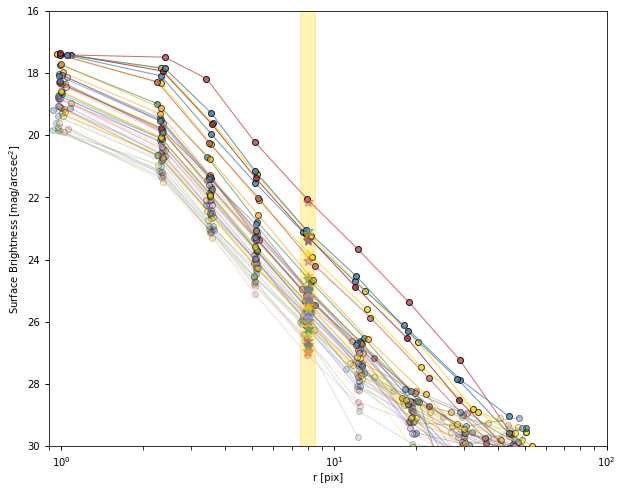

In [17]:
res_Rnorm, (img_s, ma_s, bk_s, cen_s) = compute_Rnorm_table(df_SE_target, SE_catalog=SE_cat_full, return_full=True)

table_res_Rnorm = Table(np.hstack([df_SE_target['NUMBER'].values[:, None],
                                   df_SE_target['X_IMAGE'].values[:, None],
                                   df_SE_target['Y_IMAGE'].values[:, None], res_Rnorm]), 
                     names=['NUMBER','X_IMAGE','Y_IMAGE','mean','med','std','sky'], dtype=['int']+['float']*6)
if save:
    table_res_Rnorm.write('Rnorm_8pix_15mag_X%sY%s.txt'%(patch_Xmin, patch_Ymin), overwrite=True, format='ascii')

if draw:
    import random
    colour = [ "indianred", "steelblue", "seagreen", "gold", "plum", "orange", "gray", "brown" ]
    random.seed(42)
    rand_colours = [random.choice(colour) for i in range(50)]
    
    z_mean_s, z_med_s, z_std_s, sky_mean_s = res_Rnorm.T

    plt.figure(figsize=(10,8))
    for num, rmag, sky_m, c in zip(df_SE_target["NUMBER"],df_SE_target["RMAG_AUTO"], sky_mean_s, rand_colours):
        img, ma, cen = img_s[num], ma_s[num], cen_s[num]
        alpha = min(0.2*(16-rmag), 0.9) 
        r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(img, cen=cen, mask=ma, 
                                                     ZP=ZP, sky_mean=sky_m, sky_std=std,
                                                     xunit="pix", yunit="SB", color=c, lw=1, alpha=alpha,
                                                     core_undersample=False, plot_line=False)

    plt.fill_betweenx([30, 16.], x1=7.5, x2=8.5, color="gold", alpha=0.3)
    
    for z_m, z_std, sky_m, c in zip(z_mean_s, z_std_s, sky_mean_s, rand_colours):
        plt.plot(8, Intensity2SB(z_m, sky_m, ZP, pix_scale),"*", ms=10, color=c, alpha=0.5, zorder=3)

    plt.ylim(30,16.)
    plt.xlim(0.9,100)